## Libraries and GPU

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
!nvidia-smi

Sat Jun  5 23:22:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    38W / 300W |    427MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
!pip install pytorch-lightning==1.2.8 --quiet
!pip install transformers==4.5.1 --quiet

     |████████████████████████████████| 849kB 14.7MB/s 
     |████████████████████████████████| 276kB 53.4MB/s 
     |████████████████████████████████| 276kB 47.4MB/s 
     |████████████████████████████████| 112kB 60.8MB/s 
     |████████████████████████████████| 829kB 55.8MB/s 
     |████████████████████████████████| 1.3MB 49.8MB/s 
     |████████████████████████████████| 296kB 54.1MB/s 
     |████████████████████████████████| 143kB 64.9MB/s 
     |████████████████████████████████| 2.1MB 14.0MB/s 
     |████████████████████████████████| 901kB 57.2MB/s 
     |████████████████████████████████| 3.3MB 56.4MB/s 


In [7]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

Global seed set to 42


42

## Dataset
Importamos el dataset, quitamos los vectores utilizados para auidio y aplicamos one hot encoder para las etiquetas. 

In [8]:
data = pd.read_csv("/content/final_df (1).csv")
data.head()

,Unnamed: 0,wav_file,label_x,transcription,label_y,sig_mean,sig_std,rmse_mean,rmse_std,silence,harmonic,auto_corr_max,auto_corr_std
0,0,Ses04M_impro04_F013,5,you didn t do what i told you to do .,5,0.020815,0.026067,0.021605,0.035721,0.426030,0.168125,0.000961,0.000896
1,1,Ses05F_impro08_F002,5,laughter all right . i m sorry sir that you v...,5,0.043223,0.057611,0.044045,0.085624,0.301476,0.168869,0.004593,0.005777
2,2,Ses03F_script03_1_F002,3,i mean nobody knows we re here except for fred...,3,0.010965,0.013614,0.011308,0.019041,0.400231,0.168714,0.000289,0.000249
3,3,Ses03M_script02_2_F048,1,i am sorry augie .,1,0.001159,0.001358,0.001211,0.002229,0.000000,0.168040,0.000008,0.000004
4,4,Ses05M_script03_1_F000,3,do you think it s them ?,3,0.011315,0.012433,0.011791,0.014174,0.244586,0.169257,0.000225,0.000119


In [9]:
df = data.loc[:,['transcription', 'label_y']]
df = df.rename(columns = {'transcription':'text', 'label_y':'label'})
df.head()

,text,label
0,you didn t do what i told you to do .,5
1,laughter all right . i m sorry sir that you v...,5
2,i mean nobody knows we re here except for fred...,3
3,i am sorry augie .,1
4,do you think it s them ?,3


In [10]:
df = pd.get_dummies(df.label, prefix='emotion')
df['text'] = data.transcription

In [11]:
df.head()

,emotion_0,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,text
0,0,0,0,0,0,1,you didn t do what i told you to do .
1,0,0,0,0,0,1,laughter all right . i m sorry sir that you v...
2,0,0,0,1,0,0,i mean nobody knows we re here except for fred...
3,0,1,0,0,0,0,i am sorry augie .
4,0,0,0,1,0,0,do you think it s them ?


In [12]:
train_df, val_df = train_test_split(df, test_size=0.05)
train_df.shape, val_df.shape

((7146, 7), (377, 7))

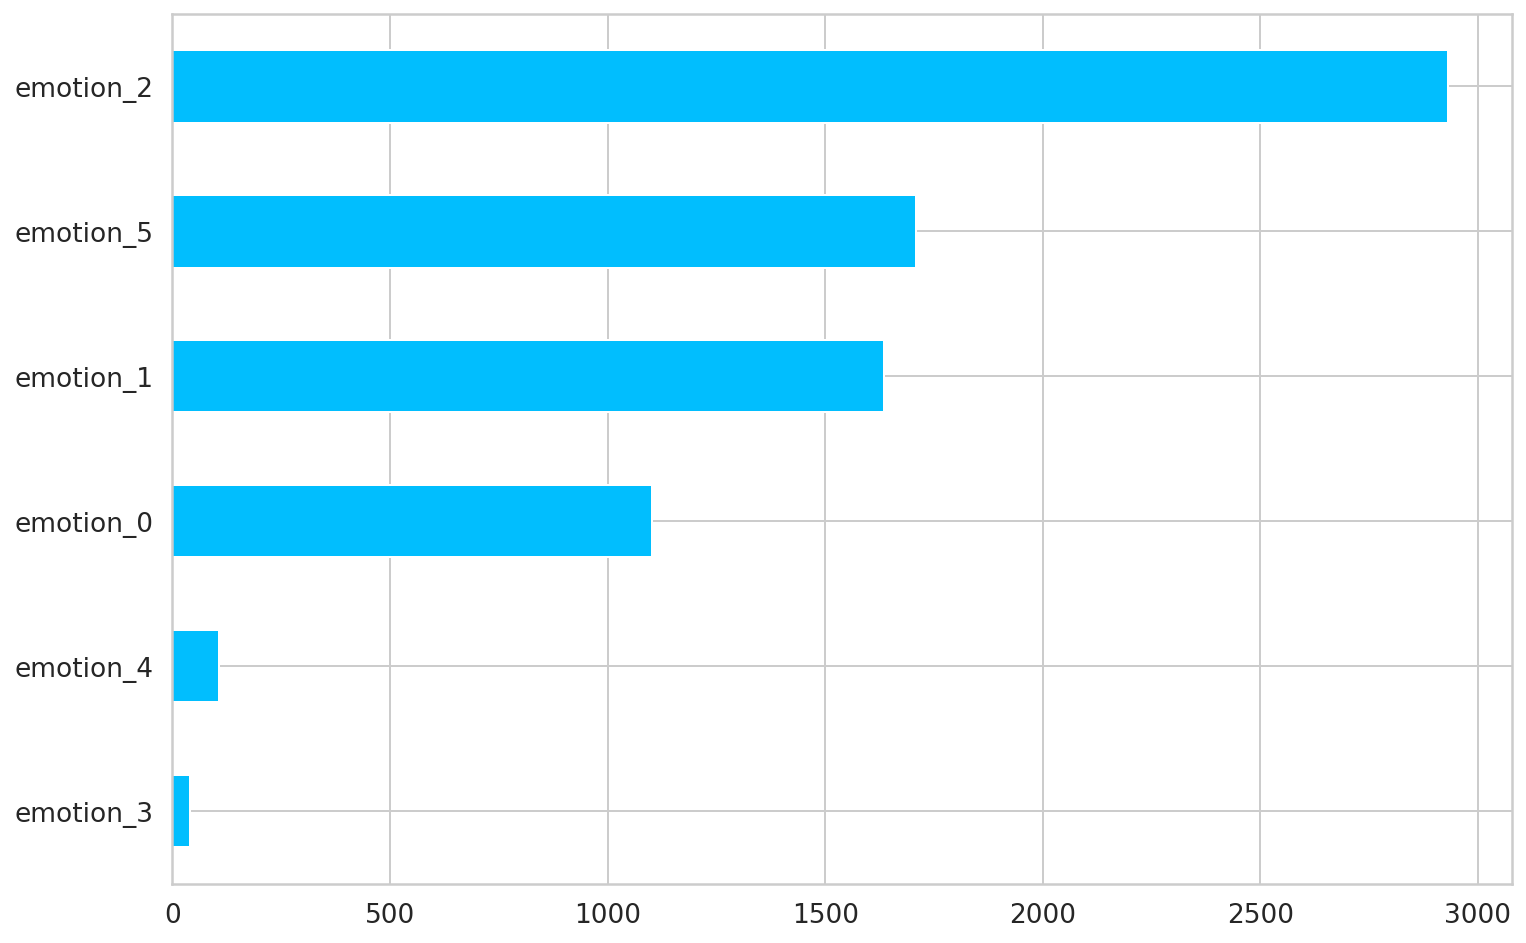

In [13]:
LABEL_COLUMNS = df.columns.tolist()[:-1]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

In [14]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [15]:
sample_row = df.iloc[16]
sample_comment = sample_row.text
sample_labels = sample_row[LABEL_COLUMNS]

print(sample_comment)
print()
print(sample_labels.to_dict())

i know . oh my god . oh my god joe i am so happy for you . well you know what that means ?

{'emotion_0': 0, 'emotion_1': 0, 'emotion_2': 0, 'emotion_3': 0, 'emotion_4': 1, 'emotion_5': 0}


In [16]:
encoding = tokenizer.encode_plus(
  sample_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [17]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

In [18]:
encoding["input_ids"].squeeze()[:20]

tensor([ 101,  178, 1221,  119, 9294, 1139, 5540,  119, 9294, 1139, 5540,  179,
        7745,  178, 1821, 1177, 2816, 1111, 1128,  119])

In [19]:
encoding["attention_mask"].squeeze()[:20]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [20]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])

['[CLS]', 'i', 'know', '.', 'oh', 'my', 'god', '.', 'oh', 'my', 'god', 'j', '##oe', 'i', 'am', 'so', 'happy', 'for', 'you', '.']


In [21]:
MAX_TOKEN_COUNT = 512

In [23]:
class EmotionsCommentsDataset(Dataset):

  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: BertTokenizer, 
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    comment_text = data_row.text
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

In [24]:
train_dataset = EmotionsCommentsDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)
sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

In [25]:
sample_item["comment_text"]

'what the lady what ? the janitor ?'

In [26]:
sample_item["labels"]

tensor([0., 0., 1., 0., 0., 0.])

In [27]:
sample_item["input_ids"].shape

torch.Size([512])

# Tokenization

In [28]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

In [29]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=2)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([8, 512]), torch.Size([8, 512]))

In [30]:
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])

In [31]:
output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([8, 512, 768]), torch.Size([8, 768]))

In [32]:
bert_model.config.hidden_size

768

## Training

In [33]:
class EmotionsCommentDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = EmotionsCommentsDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = EmotionsCommentsDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [34]:
N_EPOCHS = 10
BATCH_SIZE = 12

data_module = EmotionsCommentDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

In [35]:
class EmotionsCommentTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)    
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):
    
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)


  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [36]:
dummy_model = nn.Linear(2, 1)

optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)

warmup_steps = 20
total_training_steps = 100

scheduler = get_linear_schedule_with_warmup(
  optimizer, 
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)

learning_rate_history = []

for step in range(total_training_steps):
  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])

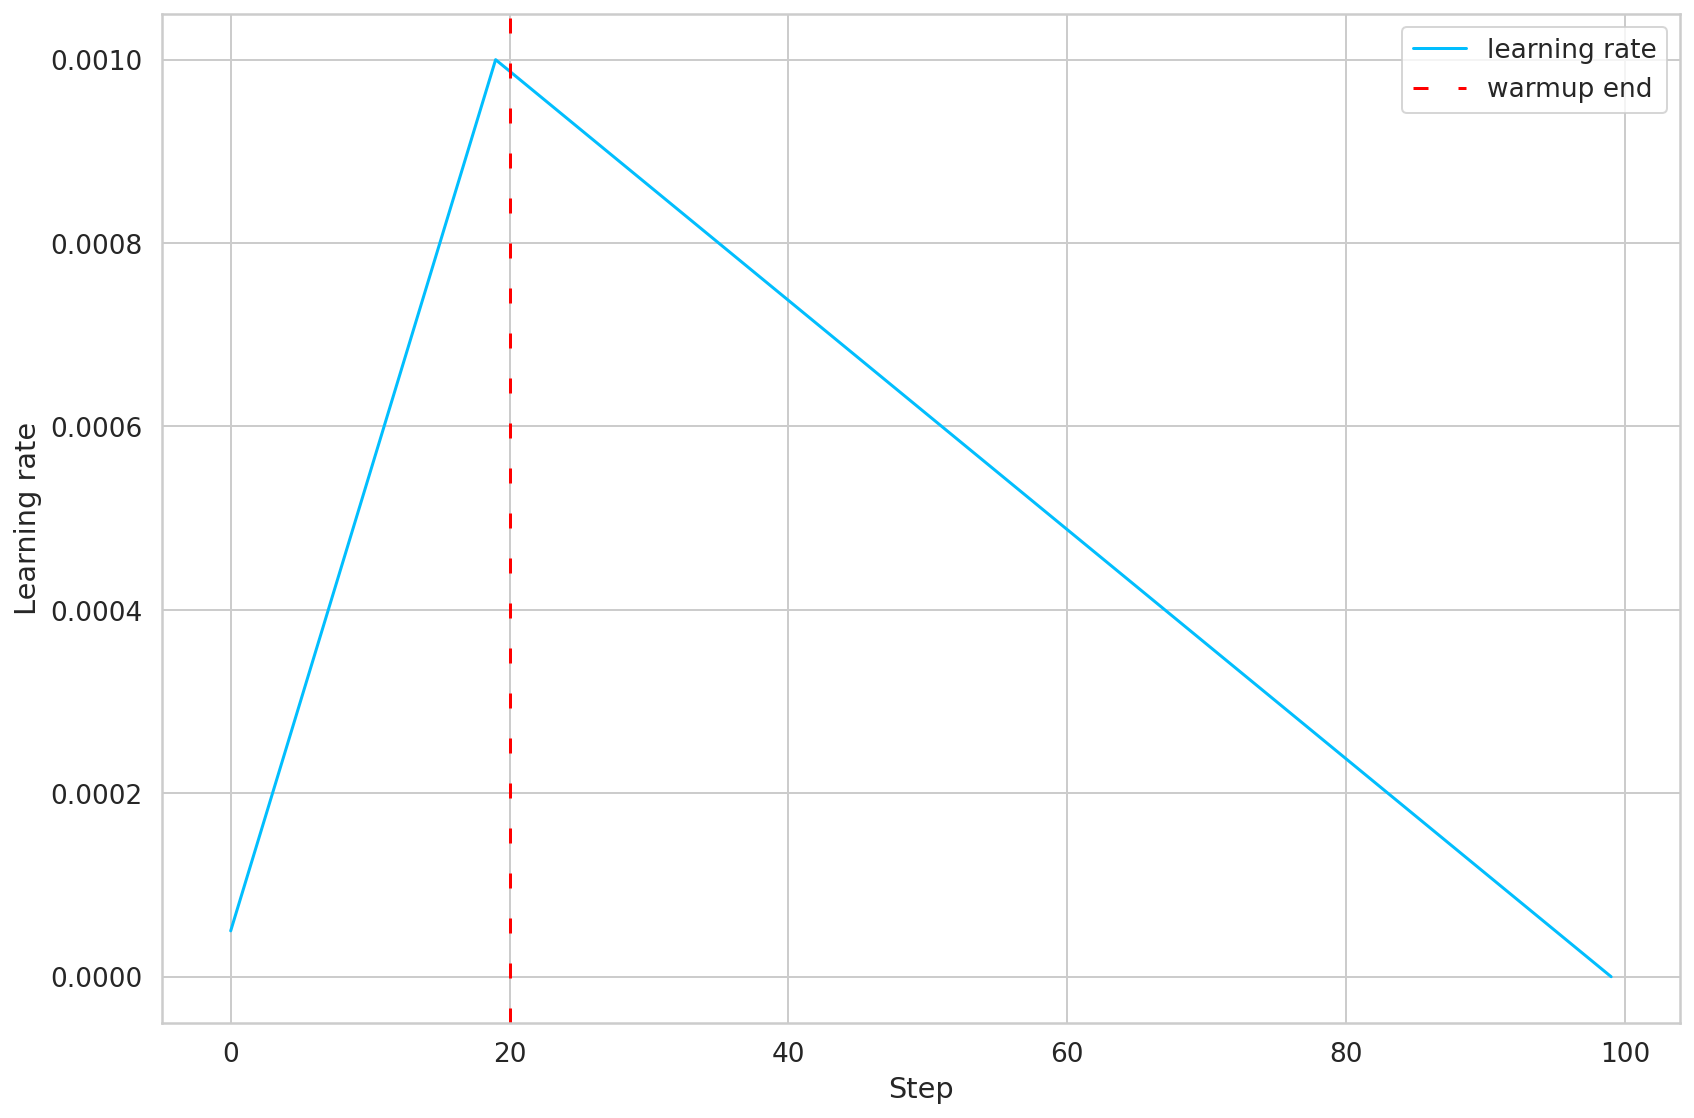

In [37]:
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();

In [38]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [39]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(1190, 5950)

In [40]:
model = EmotionsCommentTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps 
)

In [41]:
!rm -rf lightning_logs/
!rm -rf checkpoints/

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
checkpoint_callback = ModelCheckpoint(
  dirpath="/content/drive/MyDrive/AAA/checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [44]:
logger = TensorBoardLogger("lightning_logs", name="Emotions-comments")

In [45]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [46]:
trainer = pl.Trainer(
  logger=logger,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
  progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [47]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 4.6 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.260   Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)


Epoch 0, global step 595: val_loss reached 0.36686 (best 0.36686), saving model to "/content/drive/MyDrive/AAA/checkpoints/best-checkpoint.ckpt" as top 1


Epoch 1, global step 1191: val_loss reached 0.27466 (best 0.27466), saving model to "/content/drive/MyDrive/AAA/checkpoints/best-checkpoint.ckpt" as top 1


Epoch 2, global step 1787: val_loss reached 0.24410 (best 0.24410), saving model to "/content/drive/MyDrive/AAA/checkpoints/best-checkpoint.ckpt" as top 1


Epoch 3, step 2383: val_loss was not in top 1


Epoch 4, step 2979: val_loss was not in top 1


1

In [48]:
trainer.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.24410244822502136}
--------------------------------------------------------------------------------


[{'test_loss': 0.24410244822502136}]

# **Checkpoint  and predictions**

In [49]:
trained_model = EmotionsCommentTagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = EmotionsCommentsDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device), 
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

In [51]:
accuracy(predictions, labels, threshold=0.5)

tensor(0.8939)

In [52]:
predictions, labels

(tensor([[0.3465, 0.0435, 0.4334, 0.0092, 0.0125, 0.0625],
         [0.0193, 0.2113, 0.2375, 0.0025, 0.0049, 0.5116],
         [0.0582, 0.1107, 0.5021, 0.0029, 0.0060, 0.2491],
         ...,
         [0.9230, 0.0458, 0.0627, 0.0200, 0.0414, 0.0357],
         [0.4075, 0.0168, 0.5173, 0.0059, 0.0074, 0.0713],
         [0.0186, 0.0695, 0.5771, 0.0069, 0.0078, 0.2979]]),
 tensor([[0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 1],
         [0, 0, 1, 0, 0, 0],
         ...,
         [1, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0],
         [0, 0, 1, 0, 0, 0]], dtype=torch.int32))

In [53]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

AUROC per tag
emotion_0: 0.9138165712356567
emotion_1: 0.9412291049957275
emotion_2: 0.8308823704719543
emotion_3: 0.9920213222503662
emotion_4: 0.6895160675048828
emotion_5: 0.8354446887969971


In [109]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print(classification_report(
  y_true, 
  y_pred, 
  target_names=LABEL_COLUMNS, 
  zero_division=0
))

              precision    recall  f1-score   support

   emotion_0       0.65      0.75      0.70        52
   emotion_1       0.88      0.72      0.79        69
   emotion_2       0.71      0.65      0.68       156
   emotion_3       0.00      0.00      0.00         1
   emotion_4       0.33      0.20      0.25         5
   emotion_5       0.64      0.41      0.50        94

   micro avg       0.71      0.61      0.66       377
   macro avg       0.54      0.46      0.49       377
weighted avg       0.71      0.61      0.65       377
 samples avg       0.61      0.61      0.61       377



In [110]:
import seaborn as sn
import numpy as np

predictions_arg=[np.argmax(i) for i in predictions.numpy()]

In [111]:
labels_arg=[np.argmax(i) for i in labels.numpy()]

In [115]:
from sklearn.metrics import confusion_matrix
conf_mat= confusion_matrix(labels_arg, predictions_arg)

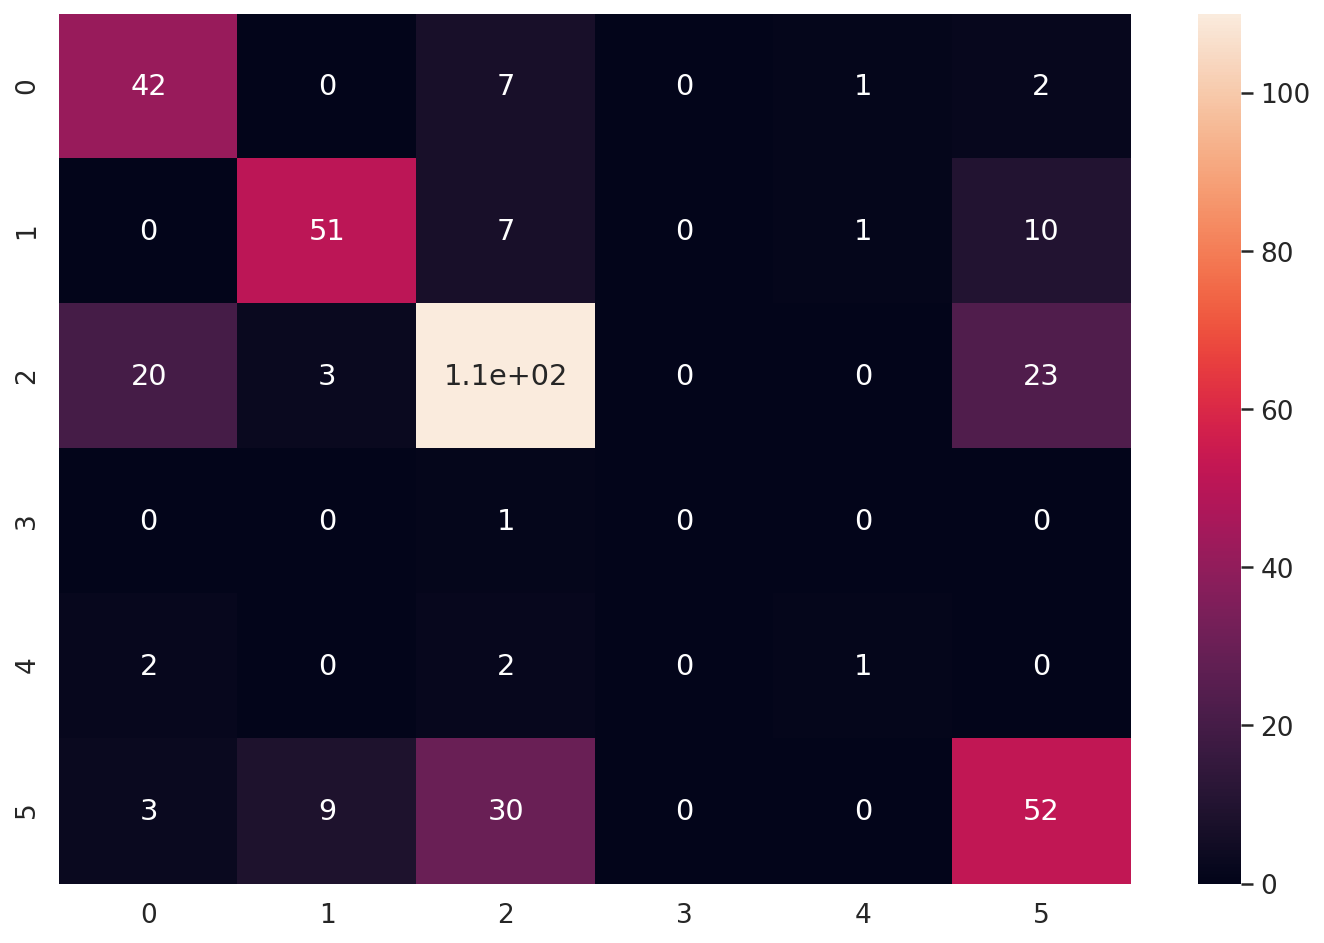

In [116]:
sn.heatmap(conf_mat,annot=True)